<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter2/2_2_PyMC3%E3%81%AE%E6%A6%82%E8%A6%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title install packages
!pip install watermark

# 簡単なモデリングの例

In [2]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.8)
cmap = plt.get_cmap("tab10")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
# 観測データ
y_obs = [1, 0, 0, 1, 1, 1, 0, 1, 1, 0]

# モデルの定義
with pm.Model() as model:
    # 推論対象とするパラメータの事前分布
    theta = pm.Uniform('theta', lower=0, upper=1)
    # 尤度関数（観測変数が従う確率分布）、今回はshapeは省略可能
    y = pm.Bernoulli('y', p=theta, shape=len(y_obs), observed=y_obs)

In [4]:
# 参考
print(model.basic_RVs)

[theta_interval__ ~ TransformedDistribution, y ~ Bernoulli]


Text(0.5, 1.0, 'logit function')

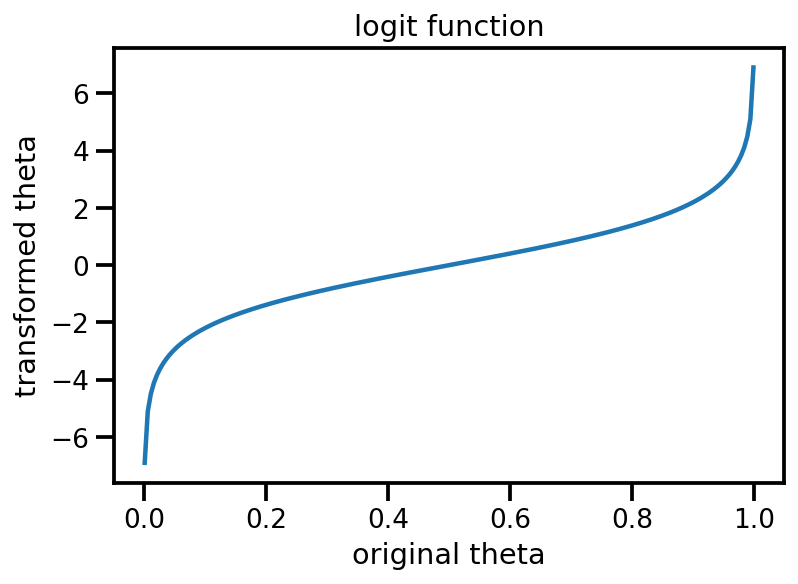

In [5]:
from scipy.special import expit
a, b = 0, 1

# x=0,1ではそれぞれ-inf, +infになるので、上限・下限を少しだけずらす
xx = np.linspace(a+0.001, b-0.001, 200)
yy = np.log(xx) - np.log(1 - xx)
plt.plot(xx, yy)
plt.xlabel("original theta")
plt.ylabel("transformed theta")
plt.title("logit function")

In [6]:
with model:
    # MCMCによる推論
    trace = pm.sample(
        draws=6000, 
        tune=2000, 
        step=pm.NUTS(), 
        chains=3, 
        random_seed=1, 
        return_inferencedata=True)

Sequential sampling (3 chains in 1 job)
NUTS: [theta]


Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 23 seconds.


In [7]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc12f4e5f10>,
      dtype=object)

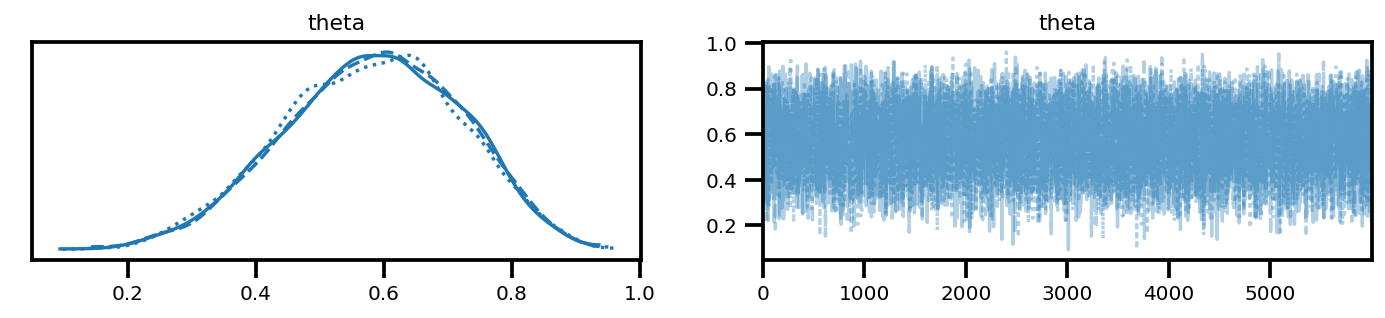

In [8]:
az.plot_trace(trace)

In [9]:
s = az.summary(trace)
display(s)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.581,0.138,0.322,0.829,0.002,0.001,7890.0,11166.0,1.0


In [10]:
print(az.rhat(trace))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 1.0


true posterior mean: 0.583


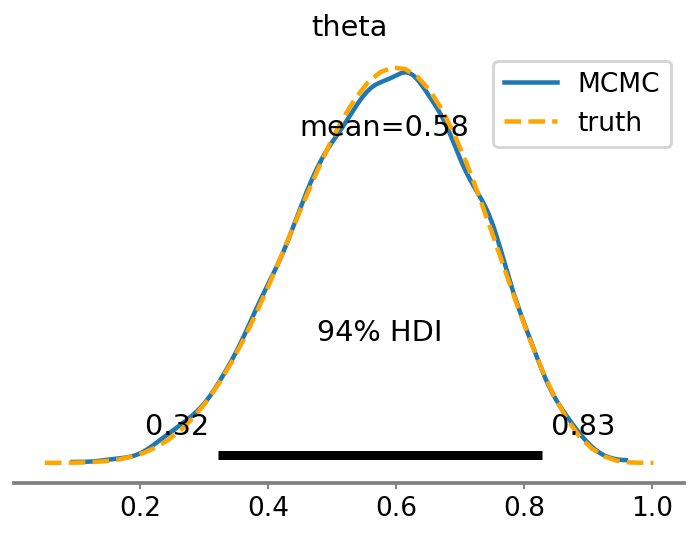

In [11]:
from scipy import stats

N, n = len(y_obs), np.sum(y_obs)
true_posterior = stats.beta(1 + n, 1 + N - n)

ax = az.plot_posterior(trace)
ax.lines[0].set_label('MCMC')

xx = np.linspace(*ax.get_xlim())
ax.plot(xx, true_posterior.pdf(xx), ls='--', color='orange', label='truth')
ax.legend()

print('true posterior mean: {:.3f}'.format(true_posterior.mean()))

In [12]:
%load_ext watermark
%watermark --iversions

IPython   : 5.5.0
seaborn   : 0.11.2
numpy     : 1.21.6
arviz     : 0.12.1
pymc3     : 3.11.4
scipy     : 1.4.1
matplotlib: 3.2.2

